# Unit Commitment Economic Dispatch (UCED)

This notebook was adapted from Jesse D. Jenkins and Michael R. Davidson to use Python instead of Julia. The original notebook can be found here: https://github.com/Power-Systems-Optimization-Course/power-systems-optimization/blob/master/Notebooks/05-Unit-Commitment.ipynb.

This notebook will illustrate how to optimize the economic dispatch of power generators while accounting for binary startup (called "commitment") decisions, constraints, and costs of thermal generators. The goal is to minimize the short-run production costs of meeting electricity demand, subject to the constraints of operating systems with large amounts of (inflexible) thermal generation. Accounting for these commitment (binary variable) constraints requires significant computational trade-offs.

*****

We build up the model in several stages. We first start with the simplest model that incorporates unit commitment decisions in order to understand the logic of three-variable commitment formulations.

Next, we introduce moderate complexity through the addition of ramp constraints to account for startups and shutdowns.

Finally, we model a more realistic unit commitment that includes reserves&mdash;an important feature of day-ahead scheduling in power systems.

## Introduction to unit commitment

Engineering considerations severely limit the possible output ranges of power plants. System operators need to be aware of these limitations when scheduling generation to meet demand. Thermal power plants, in particular, due to their complex designs, thermodynamic cycles, and material properties, can be particularly challenging. In practice, due to the times involved in bringing these power plants online, much of this scheduling is done day-ahead, which gives rise to the need for a day-ahead market.

**Unit commitment economic dispatch** (UCED) is the problem of minimizing short-run costs of production inclusive of production and startup costs, in order to meet a given demand and considering relevant engineering constraints of the generators. This notebook, for simplicity, only considers a single-bus case, while typical formulations usually include a simplified network representation.

## Simple unit commitment

We start with the simplest case that incorporates unit commitment.


$$
\begin{align}
\min \ & \sum_{g \in G, t \in T} VarCost_g \times GEN_{g,t} + \sum_{g \in G_{thermal}, t \in T} StartUpCost_g \times START_{g,t} \\
\end{align}
$$
$$
\begin{align}
\text{s.t.} & \\
 & \sum_{g} GEN_{g,t} = Demand_t & \forall \quad t \in T \\
 & GEN_{g,t} \leq Pmax_{g,t} & \forall \quad g \notin G_{thermal} , t \in T \\
 & GEN_{g,t} \geq Pmin_{g,t} & \forall \quad g \notin G_{thermal} , t \in T \\
 & GEN_{g,t} \leq Pmax_{g,t} \times COMMIT_{g,t} & \forall \quad g \in G_{thermal} , t \in T \\
 & GEN_{g,t} \geq Pmin_{g,t} \times COMMIT_{g,t} & \forall \quad g \in G_{thermal} , t \in T \\
 & COMMIT_{g,t} \geq \sum_{t'≥t-MinUp_g}^{t} START_{g,t} & \forall \quad g \in G_{thermal} , t \in T \\
 & 1-COMMIT_{g,t} \geq \sum_{t'≥t-MinDown_g}^{t} SHUT_{g,t} &\forall \quad g \in G_{thermal} , t \in T \\
  & COMMIT_{g,t+1} - COMMIT_{g,t} =&\\
 & \quad START_{g,t+1} - SHUT_{g,t+1} &\forall \quad G_{thermal} \in G , t = 1..T-1
\end{align}
$$


The **decision variables** in the above problem:

- $GEN_{g}$, generation (in MW) produced by each generator, $g$
- $START_{g,t}$, startup decision (binary) of thermal generator $g$ at time $t$
- $SHUT_{g,t}$, shutdown decision (binary) of thermal generator $g$ at time $t$
- $COMMIT_{g,t}$, commitment status (binary) of generator $g$ at time $t$

The **parameters** are:

- $Pmin_g$, the minimum operating bounds for generator $g$ (based on engineering or natural resource constraints)
- $Pmax_g$, the maximum operating bounds for generator $g$ (based on engineering or natural resource constraints)
- $Demand$, the demand (in MW)
- $VarCost_g = VarOM_g + HeatRate_g \times FuelCost_g$, the variable cost of generator $g$
- $StartUpCost_g$, the startup cost of generator $g$
- $MinUp_g$, the minimum up time of generator $g$, or the minimum time after start-up before a unit can shut down
- $MinDown_g$, the minimum down time of generator $g$, or the minimum time after shut-down before a unit can start again

In addition, we introduce a few different sets:

- $G$, the set of all generators
- $G_{thermal} \subset G$, the subset of thermal generators for which commitment is necessary
- $T$, the set of all time periods over which we are optimizing commitment and dispatch decisions

Finally, the **three-variable commitment equations** capture the basic logic of commitment:

- Units incur costs when they startup (not when they shutdown)
- Units must stay on (and off) for a minimum period of time&mdash;in lieu of explicitly enforcing a startup trajectory
- Some summations (simplified here) will need to be modified near the beginning of the time period

There are some further resources at the bottom for alternative and/or more complex formulations of the UCED problem.

Let's implement this version.

### 1. Load packages

First, let's install and load the Python packages we'll need to work with here.

In [ ]:
!pip install gurobipy
!pip install gurobipy_pandas

In [ ]:
import gurobipy as gp
from gurobipy import GRB
import gurobipy_pandas as gppd
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from google.colab import drive

# allow access to google drive
drive.mount('/content/drive')

### 2. Load and format data

We will use data loosely based on San Diego Gas and Electric (SDG&E, via the [PowerGenome](https://github.com/gschivley/PowerGenome) data platform) including a few neighboring generators and adjustments to make the problem easy to solve, consisting of:

- 33 generators (we added a few more to ensure we can provide enough reserves)
- estimated hourly demand for 2020 (net load at the transmission substation level after subtracting 600MW of behind-the-meter solar from original demand)
- variable generation capacity factors
- estimated natural gas fuel costs

In order to demonstrate the impacts of unit commitment, we will use a high solar sensitivity case with 3,500 MW of solar PV to produce large variations in net load required to meet demand (similar to [California's infamous "Duck Curve"](https://www.caiso.com/Documents/FlexibleResourcesHelpRenewables_FastFacts.pdf)).

In [3]:
datadir = "drive/MyDrive/Colab Notebooks/CE4110_6250/UCED_data/"
gen_info = pd.read_csv(datadir + "Generators_data.csv")
fuels = pd.read_csv(datadir + "Fuels_data.csv")
loads = pd.read_csv(datadir + "Demand.csv")
gen_variable = pd.read_csv(datadir + "Generators_capacity_factors.csv")

**Construct generator dataframe**

In [ ]:
# Keep columns relevant to our UCED model
gen_info = gen_info.iloc[:,0:26] # first 26 columns
gen_df = gen_info.join(fuels.set_index("Fuel"), on="Fuel")
gen_df.rename(columns={"Cost_per_MMBtu": "Fuel_cost"},inplace=True)
gen_df["Fuel_cost"].fillna(0) # replace NAs for fuel cost with 0

# create "is_variable" column to indicate if this is a variable generation source (e.g. wind, solar):
gen_df["Is_variable"] = False
indices = [i for i in gen_df.index if gen_df["Resource"][i] in ["onshore_wind_turbine","small_hydroelectric","solar_photovoltaic"]]
gen_df["Is_variable"].iloc[indices] = True

# create full name of generator (including geographic location and cluster number)
#  for use with variable generation dataframe
gen_df["Generator"] = gen_df["region"] + "_" + gen_df["Resource"] + "_" + gen_df["cluster"].astype("str") + ".0"

# remove generators with no capacity (e.g. new build options that we'd use if this was capacity expansion problem)
gen_df = gen_df[gen_df["Existing_Cap_MW"] > 0]

gen_df.set_index("Generator",inplace=True)
gen_df

**Modify load and variable generation dataframes**

In [ ]:
# 1. Convert from GMT to GMT-8
gen_variable["Hour"] = np.mod(gen_variable["Hour"]-9, 8760)
gen_variable = gen_variable.sort_values(by="Hour")
loads["Hour"] = np.mod(loads["Hour"]-9, 8760)
loads = loads.sort_values(by="Hour")
loads.set_index("Hour",inplace=True)
gen_variable.set_index("Hour",inplace=True)
gen_variable

In [ ]:
### create multi-indexed dataframe for each decision variable index
list_of_indices = [
    list(gen_df.index), # generators
    list(gen_variable.index) # hours
]

multi_idx = pd.MultiIndex.from_product(list_of_indices, names=["Generator", "Hour"])
np.unique(multi_idx.get_level_values(0))

In [ ]:
all_gen_df = pd.DataFrame(index = multi_idx)
all_gen_df

In [ ]:
thermal_generators = gen_df.index[np.where(gen_df["Up_time"] > 0)[0]]
thermal_gen_df = all_gen_df.loc[thermal_generators.tolist()]
thermal_gen_df

In [ ]:
nonthermal_generators = gen_df.index[np.where(gen_df["Up_time"] == 0)[0]]
nonthermal_gen_df = all_gen_df.loc[nonthermal_generators.tolist()]
nonthermal_gen_df

### 3. Setup problem for a spring day's unit commitment with high solar

In [ ]:
# A spring day
n=100
T_period = np.arange(n*24,(n+1)*24)

# High solar case: 3,500 MW
gen_df_sens = gen_df.copy()
gen_df_sens["Existing_Cap_MW"][np.where(gen_df_sens["Resource"] == "solar_photovoltaic")[0]]= 3500

# Note we reduce the MIP gap tolerance threshold here to increase tractability
# Here we set it to a 1% gap (mip_gap=0.01), meaning that we will terminate once we have
# a feasible integer solution guaranteed to be within 1% of the objective
# function value of the optimal solution (e.g. the upper and lower bound are within 1% of
# each other as Gurobi traverses the branch and bound tree).
# Gurobi's default MIP gap is 0.0001 (0.01%), which can take a longer time for
# any complex problem. So it is important to set this to a realistic value.
mip_gap = 0.0001

In [ ]:
# subset only hours in T_period from all_gen_df, thermal_gen_df and nonthermal_gen_df
idx = pd.IndexSlice
all_gen_df_springday = all_gen_df.loc[idx[:,T_period],:]
all_gen_df_springday

In [ ]:
thermal_gen_df_springday = thermal_gen_df.loc[idx[:,T_period],:]
thermal_gen_df_springday

In [ ]:
nonthermal_gen_df_springday = nonthermal_gen_df.loc[idx[:,T_period],:]
nonthermal_gen_df_springday

In [ ]:
loads_springday = loads["Demand"].iloc[T_period]
loads_springday

### 4. Set up and solve problem with gurobipy-pandas

In [ ]:
# create environment with Gurobi academic license
# CHANGE THESE TO THE VALUES FOR YOUR LICENSE
params = {
"WLSACCESSID": '69c0357e-257d-4855-a3f0-446b8e822abd',
"WLSSECRET": '11082e14-04a8-4439-a62d-f3acd3d46920',
"LICENSEID": 2471772,
}
env = gp.Env(params=params)

In [16]:
UCED = gp.Model('UCED model', env=env)
UCED.Params.MIPGap = mip_gap

Define decision variables:
* generation at each generator each hour
* commitment at each thermal generator (whether it is on or off each hour)
* whether a thermal generator is turned on each hour
* whether a thermal generator is shut off each hour

In [ ]:
# Decision variables
GEN = (all_gen_df_springday.gppd.add_vars(UCED, name="GEN", vtype=GRB.CONTINUOUS))
GEN

In [ ]:
COMMIT = (thermal_gen_df_springday.gppd.add_vars(UCED, name="COMMIT", vtype=GRB.BINARY))
COMMIT

In [ ]:
START = (thermal_gen_df_springday.gppd.add_vars(UCED, name="START", vtype=GRB.BINARY))
START

In [ ]:
SHUT = (thermal_gen_df_springday.gppd.add_vars(UCED, name="SHUT", vtype=GRB.BINARY))
SHUT

Define constraints:
1. Total generation across generators = demand every hour

In [ ]:
# non-negativity constraints assumed, just add demand, capacity and unit commitment constraints
# 1. demand constraint
c1_demand = gppd.add_constrs(UCED, GEN["GEN"].groupby("Hour").sum(), GRB.EQUAL, loads_springday, name="c1_demand")
c1_demand

2. Thermal generators must generator at least the minimum power and no more than their capacity

In [ ]:
# capacity constraints
# 2. thermal generators requiring commitment
c2_min_thermal = gppd.add_constrs(UCED, GEN["GEN"].loc[thermal_generators.tolist()], GRB.GREATER_EQUAL,
                                  COMMIT["COMMIT"] * gen_df_sens.loc[thermal_generators.tolist()]["Existing_Cap_MW"] * gen_df_sens.loc[thermal_generators.tolist()]["Min_power"],
                                  name = "c2_min_thermal")
print(c2_min_thermal)

c2_max_thermal = gppd.add_constrs(UCED, GEN["GEN"].loc[thermal_generators.tolist()], GRB.LESS_EQUAL,
                                  COMMIT["COMMIT"] * gen_df_sens.loc[thermal_generators.tolist()]["Existing_Cap_MW"],
                                  name = "c2_max_thermal")
print(c2_max_thermal)

3. Non-thermal, non-variable generators cannot generator more than their capacity each hour, and non-thermal, variable generators cannot generate more than their capacity factor * capacity each hour

In [ ]:
# 3. nonthermal generation cannot exceed capacity*capacity factor
cap_facs = (gen_df_sens.loc[nonthermal_generators.tolist()]["Existing_Cap_MW"] * gen_variable[nonthermal_generators.tolist()].loc[T_period]).stack()
cap_facs = cap_facs.to_frame()
cap_facs.columns = ["Capacity"]
cap_facs.index.set_names(["Hour","Generator"],inplace=True)
cap_facs = cap_facs.swaplevel()
print(cap_facs)
print(GEN["GEN"].loc[nonthermal_generators.tolist()])

c3_nonthermal_capfac = gppd.add_constrs(UCED, GEN["GEN"].loc[nonthermal_generators.tolist()], GRB.LESS_EQUAL, cap_facs["Capacity"], name = "c3_nonthermal_capfac")
c3_nonthermal_capfac

4. Unit commitment constraints: cannot start up if down time has not been exceeded, cannot turn off if time on has not been exceeded.

In [ ]:
# unit commitment constraints
# 4. Minimum up time and down time

def timeConstraints(model, gen_df_sens, COMMIT, TIME, time_label, var_label, timegap, constraint_label):
  # subset generators from gen_df_sens whose Up/Down time (time_label) = timegap
  time = gen_df_sens[gen_df_sens[time_label] == timegap].index
  TIMEgap = TIME.loc[time.tolist(),:]

  # create variable that computes the sum of the START/STOP (var_label) values for the past timegap time steps
  TIMEgap[var_label + "_SUM"] = np.empty(np.shape(TIMEgap)[0])

  # get timegap-period rolling sum
  # note: (TIME.groupby("Generator")[var_label].transform(lambda x: x.rolling(timegap+1).sum()) didn't work) b/c it couldn't sum over the constraints, only numbers
  for g in time.tolist():
    for h in T_period:
      if h == T_period[0]:
        TIMEgap.loc[g,h][var_label + "_SUM"] = TIMEgap.loc[g,h][var_label]
      elif h <= T_period[timegap]:
        TIMEgap.loc[g,h][var_label + "_SUM"] = TIMEgap.loc[g,h-1][var_label + "_SUM"] + TIMEgap.loc[g,h][var_label]
      else:
        TIMEgap.loc[g,h][var_label + "_SUM"] = TIMEgap.loc[g,h-1][var_label + "_SUM"] + TIMEgap.loc[g,h][var_label] - TIMEgap.loc[g,h-timegap][var_label]

  constraint = gppd.add_constrs(model, COMMIT["COMMIT"].loc[time.tolist()], GRB.GREATER_EQUAL, TIMEgap[var_label + "_SUM"], name=constraint_label)

# find unique Up_time values
up_times = np.unique(gen_df_sens["Up_time"].loc[thermal_generators.tolist()])
for up_time in up_times:
  timeConstraints(UCED, gen_df_sens, COMMIT, START, "Up_time", "START", int(up_time), "c4_min_up_time_" + str(int(up_time)))

# find unique Down_time values
down_times = np.unique(gen_df_sens["Down_time"].loc[thermal_generators.tolist()])
for down_time in down_times:
  timeConstraints(UCED, gen_df_sens, COMMIT, SHUT, "Down_time", "SHUT", int(down_time), "c4_min_down_time_" + str(int(down_time)))

In [ ]:
# Commitment state
print(COMMIT["COMMIT"].loc[:,T_period[1::]])
print(COMMIT["COMMIT"].loc[:,T_period[0:-1]])
c4_commitment_status = gppd.add_constrs(UCED, np.array(COMMIT["COMMIT"].loc[:,T_period[1::]]) - np.array(COMMIT["COMMIT"].loc[:,T_period[0:-1]]), GRB.EQUAL,
                                        START["START"].loc[:,T_period[1::]] - SHUT["SHUT"].loc[:,T_period[1::]], name="c4_commitment_status")
c4_commitment_status

Define objective function: minimize costs of variable generation, non-variable generation, and startup at thermal generators

In [27]:
# Objective function
# Sum of variable costs + start-up costs for all generators and time periods
cost_gen = (GEN["GEN"] * (gen_df_sens["Var_OM_cost_per_MWh"] + gen_df_sens["Heat_rate_MMBTU_per_MWh"] * gen_df_sens["Fuel_cost"])).agg(gp.quicksum)

cost_startup = (gen_df_sens["Start_cost_per_MW"] * gen_df_sens["Existing_Cap_MW"] * START["START"]).agg(gp.quicksum)

UCED.setObjective(cost_gen + cost_startup)

Run optimization

In [ ]:
UCED.optimize()

Summarize output in data frames with binary commitment decisions at each generator each hour, total generation at each generator each hour, and total curtailment of variable generators each hour.

In [ ]:
commit = COMMIT.COMMIT.gppd.x.to_frame().unstack().transpose()
commit

In [ ]:
gen = GEN.GEN.gppd.x.to_frame().unstack().transpose()
gen

In [ ]:
curtail = gen_df_sens.loc[nonthermal_generators.tolist()]["Existing_Cap_MW"] * gen_variable[nonthermal_generators.tolist()].loc[T_period] - \
          gen.loc[:,nonthermal_generators.tolist()]
curtail

Plot a stacked bar chart of generation from each generator each hour

In [ ]:
CCGT = [col for col in gen.columns.values if "combined" in col]
CT = [col for col in gen.columns.values if "combustion" in col]

btm = gen_variable["WEC_SDGE_solar_photovoltaic_1.0"].iloc[T_period]*600
btm = btm.to_frame()
btm.set_index(gen.index,inplace=True)

gen_by_type = pd.DataFrame({"Natural Gas CT": gen[CT].sum(axis=1), "Natural Gas CCGT": gen[CCGT].sum(axis=1),
                            "Hydro PSH": gen['WEC_SDGE_hydroelectric_pumped_storage_1.0'], "Biomass": gen['WEC_SDGE_biomass_1.0'],
                            "Solar PV": gen['WEC_SDGE_solar_photovoltaic_1.0'], "Small Hydro": gen['WEC_SDGE_small_hydroelectric_1.0'],
                            "Onshore Wind": gen['WEC_SDGE_onshore_wind_turbine_1.0'],"Curtailment": curtail.sum(axis=1),
                            "Solar BTM": btm["WEC_SDGE_solar_photovoltaic_1.0"]})
gen_by_type = gen_by_type.set_index(gen_by_type.index.get_level_values(1))
gen_by_type

In [ ]:
gen_by_type["Demand"] = loads_springday
gen_by_type["Hour"] = gen_by_type.index.astype('string')
cols_to_plot = ["Hour", "Natural Gas CT", "Natural Gas CCGT", "Hydro PSH", "Biomass", "Solar PV", "Small Hydro", "Onshore Wind", "Curtailment",	"Solar BTM"]
ax = gen_by_type[["Hour", "Demand"]].plot(x="Hour",color="black")
gen_by_type[cols_to_plot].plot(x="Hour",kind="bar", stacked=True, width=1, color=["tab:brown","tab:red","tab:cyan","tab:green","yellow",
                                                   "tab:blue","tab:gray","tab:purple","tab:olive"], ax=ax).legend(loc='center left',bbox_to_anchor=(1.0, 0.5))

Notice that the combined cycle plants flatten out during the day, but don't shut down due to the need for ramping capabilities in the late afternoon/evening, when solar output falls off and evening demand remains strong. This leads to some curtailment of solar from 11:00 - 16:00. All curtailment is lumped together as the model does not accurately distinguish between whether wind, solar or hydro is curtailed, which in practice is up to the system operator and depends on a variety of factors such as location, interconnection voltage, etc.

In [ ]:
commit_by_type = pd.DataFrame({"Natural Gas CT": commit[CT].sum(axis=1), "Natural Gas CCGT": commit[CCGT].sum(axis=1)})
commit_by_type

In [ ]:
commit_by_type.plot.bar(stacked=True, width=1, color=["tab:orange","tab:blue"])

Note that units shutdown during the solar period and startup for the evening peak. However, due to the commitment constraints, not all natural gas plants can be decommitted, resulting in the observed curtailment. A large number of combustion turbines turn on to meet the evening peak.

### What if there were no Startup Costs for thermal generators? How would the energy mix and commitment decisions change?

In [ ]:
gen_df_sens["Start_cost_per_MW"] = 0

cost_startup = (gen_df_sens["Start_cost_per_MW"] * gen_df_sens["Existing_Cap_MW"] * START["START"]).agg(gp.quicksum)

UCED.setObjective(cost_gen + cost_startup)

UCED.optimize()

In [ ]:
commit = COMMIT.COMMIT.gppd.x.to_frame().unstack().transpose()
gen = GEN.GEN.gppd.x.to_frame().unstack().transpose()
curtail = gen_df_sens.loc[nonthermal_generators.tolist()]["Existing_Cap_MW"] * gen_variable[nonthermal_generators.tolist()].loc[T_period] - \
          gen.loc[:,nonthermal_generators.tolist()]

#curtail.set_index(gen.index,inplace=True)

CCGT = [col for col in gen.columns.values if "combined" in col]
CT = [col for col in gen.columns.values if "combustion" in col]

btm = gen_variable["WEC_SDGE_solar_photovoltaic_1.0"].iloc[T_period]*600
btm = btm.to_frame()
btm.set_index(gen.index,inplace=True)

gen_by_type = pd.DataFrame({"Natural Gas CT": gen[CT].sum(axis=1), "Natural Gas CCGT": gen[CCGT].sum(axis=1),
                            "Hydro PSH": gen['WEC_SDGE_hydroelectric_pumped_storage_1.0'], "Biomass": gen['WEC_SDGE_biomass_1.0'],
                            "Solar PV": gen['WEC_SDGE_solar_photovoltaic_1.0'], "Small Hydro": gen['WEC_SDGE_small_hydroelectric_1.0'],
                            "Onshore Wind": gen['WEC_SDGE_onshore_wind_turbine_1.0'],"Curtailment": curtail.sum(axis=1),
                            "Solar BTM": btm["WEC_SDGE_solar_photovoltaic_1.0"]})
gen_by_type = gen_by_type.set_index(gen_by_type.index.get_level_values(1))
gen_by_type["Demand"] = loads_springday
gen_by_type["Hour"] = gen_by_type.index.astype('string')

cols_to_plot = ["Hour", "Natural Gas CT", "Natural Gas CCGT", "Hydro PSH", "Biomass", "Solar PV", "Small Hydro", "Onshore Wind", "Curtailment",	"Solar BTM"]
ax = gen_by_type[["Hour", "Demand"]].plot(x="Hour",color="black")
gen_by_type[cols_to_plot].plot(x="Hour",kind="bar", stacked=True, width=1, color=["tab:brown","tab:red","tab:cyan","tab:green","yellow",
                                                   "tab:blue","tab:gray","tab:purple","tab:olive"], ax=ax).legend(loc='center left',bbox_to_anchor=(1.0, 0.5))

In [ ]:
commit_by_type = pd.DataFrame({"Natural Gas CT": commit[CT].sum(axis=1), "Natural Gas CCGT": commit[CCGT].sum(axis=1)})
commit_by_type.plot.bar(stacked=True, width=1, color=["tab:orange","tab:blue"])

## Extension for Homework 4

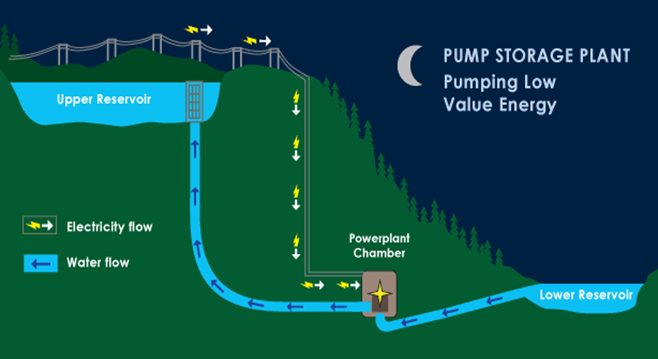

Note that units shutdown during the solar period and startup for the evening peak. However, due to the commitment constraints, not all natural gas plants can be decommitted, resulting in the observed curtailment. A large number of combustion turbines turn on to meet the evening peak.

In the data, we have a generator `hydroelectric_pumped_storage` which is a pumped hydro storage (PHS) facility. We have been treating it as a free resource, but in fact, it's a battery. The PHS equations for stored water are identical to the state of charge ($SOC$) for a battery:

\begin{align}
&SOC_t = SOC_{t-1} + \big(CHARGE_t * battery_{eff} - \frac{DISCHARGE_t}{battery_{eff}}\big)  \quad \forall t \in T\tag{1} \\  
&CHARGE_t \leq Pmax \quad \forall t \in T\tag{2}\\  
&DISCHARGE_t \leq Pmax \quad \forall t \in T\tag{3}\\
&SOC[t] \leq energy\_cap \quad \forall t \in T\tag{4}
\end{align}

<!---$SOLAR_t + DISCHARGE_t - CHARGE_t = \frac{GRIDEXPORT_t}{inverter\_eff} - GRIDIMPORT_t \times inverter\_eff \quad \forall t \in T$--->

The **decision variables** are:
* $CHARGE_t$: How much DC power to charge to PHS (i.e. how much water to pump up water to upper reservoir); continuous
* $DISCHARGE_t$: How much DC power to discharge from PHS (i.e. how much water to release down to lower reservoir through turbines); continuous
* $SOC_t$: "Storage State of Charge" representing how much energy is stored in the battery (i.e., upper reservoir storage); continuous

The **parameters** are
* $battery_{eff}=0.84$: Fraction of the stored energy that can be converted to power.
* $Pmax$: maximum power capacity of battery in MW, given in `existing_cap_mw` column of `gen_df` for `hydroelectric_pumped_storage`.
* $energy\_cap = 4 \times Pmax$: maximum energy in MWh that can be stored in the battery (i.e. upper reservoir)

For Homework 4, re-move the generation decision from the PHS generator and instead add the decision variables above with those four constraints, and one more that assumes the reservoir starts and ends the day at 50% of capacity:

$SOC[0] = SOC[T] = 0.5 \times energy\_cap \tag{5}$

With PHS acting as a battery, it is generating power when it discharges and adding load to the system/reducing generation when it charges. This changes the generation constraint to the following:

$\sum_{g \notin PHS} GEN_{g,t} + DISCHARGE_t - CHARGE_t = Demand_t \quad \forall \quad t \in T\tag{6}$

Finally, costs will be incurred for generation whenever $DISCHARGE_t+CHARGE_t>0$. This changes the objective function to the following:

$\min \sum_{g \notin PHS, t \in T} VarCost_g \times GEN_{g,t} + \sum_{g \in G_{thermal}, t \in T} StartUpCost_g \times START_{g,t} + \sum_{t \in T} VarCost_{PHS} \times (DISCHARGE_t + CHARGE_t)\tag{7}$

### Further resources

Knueven, B., Ostrowski, J., & Watson, J.-P. (2019). On Mixed Integer Programming Formulations for the Unit Commitment Problem. Optimization Online, 91. http://www.optimization-online.org/DB_FILE/2018/11/6930.pdf

Morales-Espana, G., Latorre, J. M., & Ramos, A. (2013). Tight and Compact MILP Formulation of Start-Up and Shut-Down Ramping in Unit Commitment. IEEE Transactions on Power Systems, 28(2), 1288–1296. https://doi.org/10.1109/TPWRS.2012.2222938

Morales-España, G., Ramírez-Elizondo, L., & Hobbs, B. F. (2017). Hidden power system inflexibilities imposed by traditional unit commitment formulations. Applied Energy, 191, 223–238. https://doi.org/10.1016/j.apenergy.2017.01.089

Ostrowski, J., Anjos, M. F., & Vannelli, A. (2012). Tight Mixed Integer Linear Programming Formulations for the Unit Commitment Problem. IEEE Transactions on Power Systems, 27(1), 39–46. https://doi.org/10.1109/TPWRS.2011.2162008